# Convolutional neural networks

In this unit we will learn about **Convolutional Neural Networks (CNNs)**, which are specifically designed for computer vision.

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image. 

To extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units.

In [62]:
## pytorchcv.py 파일을 다운로드합니다.
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

# torchvision, torchinfo, pytorchcv 라이브러리를 설치합니다.
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

# 필요한 라이브러리를 가져옵니다.
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv

# Fashion-MNIST 데이터셋을 로드하고, 학습 및 테스트 데이터 로더를 생성합니다.
from pytorchcv import load_fashion_mnist, train, plot_results, plot_convolution, display_dataset
load_fashion_mnist(batch_size=128) 


11473.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2024-04-19 10:57:21--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.2’

pytorchcv.py.2      100%[===================>]   6.39K  --.-KB/s    in 0s      

2024-04-19 10:57:21 (17.8 MB/s) - ‘pytorchcv.py.2’ saved [6540/6540]



11479.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


11486.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


11493.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.



They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits.

The vertical edge filter emphasizes changes in intensity that occur vertically across the image, making it useful for detecting vertical lines and edges.

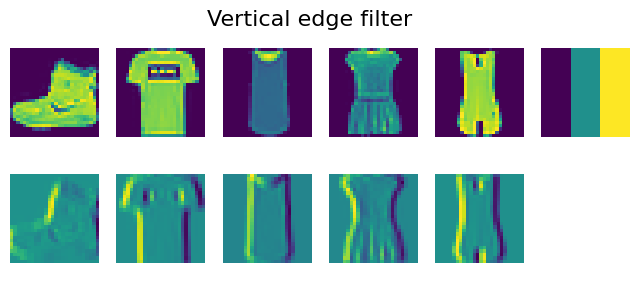

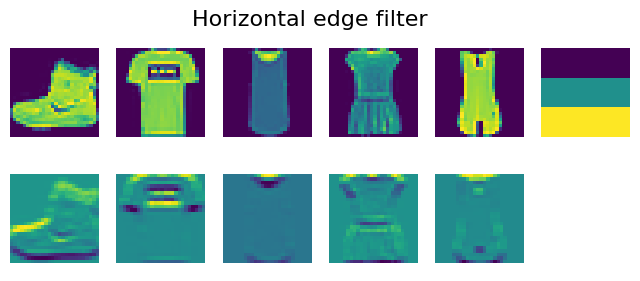

In [63]:
# 컨볼루션 연산을 시각화하는 함수를 호출합니다.
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.

To do that, we introduce **convolutional layers**.

## Covolutional layers

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1.
* `out_channels` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 

The Rectified Linear Unit (ReLU) activation function is one of the most commonly used activation functions in neural networks, especially in deep learning models. The function is defined mathematically as:

ReLU(x)=max(0,x)

Here’s what this means:

If x is greater than 0, the function returns x.
If x is less than or equal to 0, the function returns 0.

Properties of ReLU
Non-linear: While it looks like a linear function, ReLU introduces a non-linearity (a simple threshold at 0), which allows models to learn more complex patterns.
Computationally Efficient: It is very efficient to compute as it only requires checking if the input is positive or not.
Sparse Activation: In practice, ReLU results in sparse activations; i.e., only a subset of neurons in a layer are active at a given time.

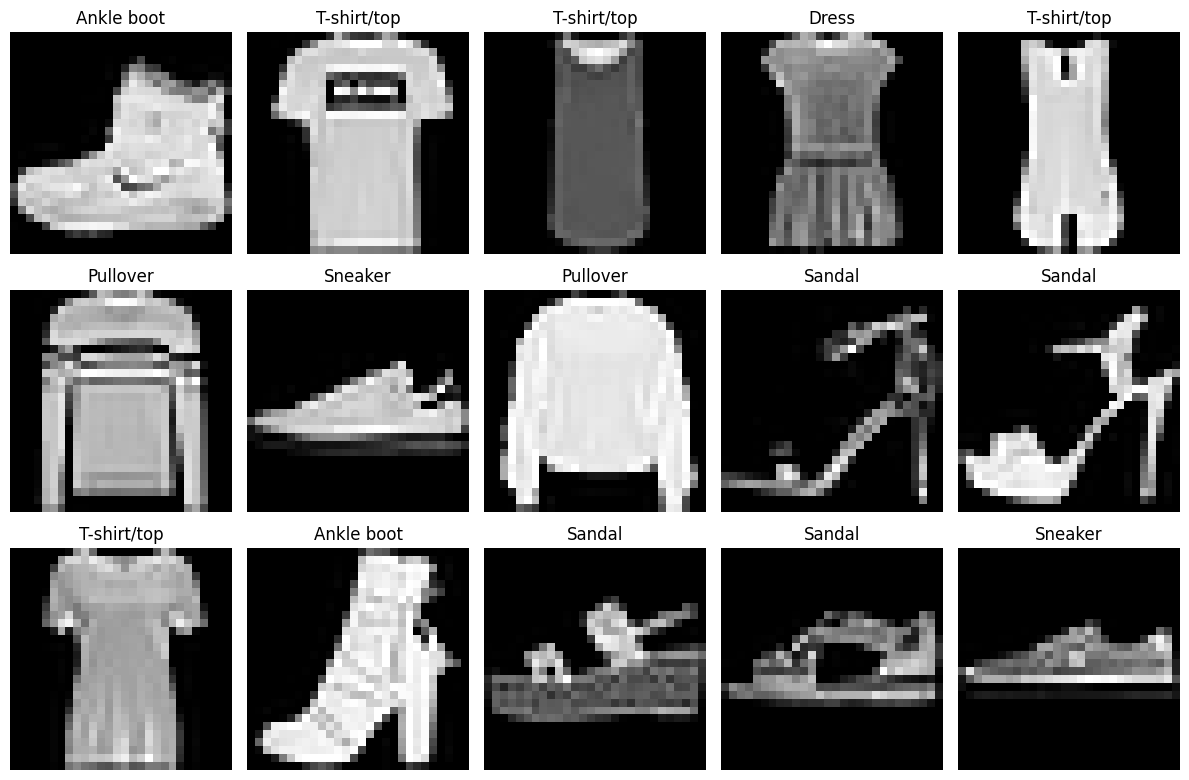

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [16, 28, 28]              160
├─MaxPool2d: 1-2                         [16, 14, 14]              --
├─Conv2d: 1-3                            [32, 14, 14]              4,640
├─MaxPool2d: 1-4                         [32, 7, 7]                --
├─Linear: 1-5                            [1, 128]                  200,832
├─Linear: 1-6                            [1, 10]                   1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (M): 2.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.83
Estimated Total Size (MB): 0.98

In [64]:
# 데이터셋 불러오기
# FashionMNIST 데이터셋을 불러오고, 훈련 데이터와 테스트 데이터로 구분합니다.
train_data = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=torchvision.transforms.ToTensor())
# root: 데이터가 저장될 경로를 지정합니다.
# train: 훈련 데이터 여부를 지정합니다. True이면 훈련 데이터, False이면 테스트 데이터를 불러옵니다.
# download: 데이터를 다운로드할지 여부를 지정합니다. True로 설정하면 인터넷에서 데이터를 다운로드합니다.
# transform: 이미지를 텐서로 변환하는 변환을 적용합니다.

# 데이터셋 시각화
# 주어진 데이터셋에서 이미지와 해당하는 레이블을 시각적으로 탐색합니다.
def visualize_dataset(dataset):
    # 클래스 레이블에 해당하는 의류 종류를 정의합니다.
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # 3x5 크기의 서브플롯을 생성합니다.
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
    # 데이터셋에서 각 이미지와 레이블을 가져와서 시각화합니다.
    for i, ax in enumerate(axes.flat):
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap='gray') # 이미지를 그레이스케일로 표시합니다.
        ax.set_title(classes[label]) # 해당하는 클래스 레이블을 타이틀로 설정합니다.
        ax.axis('off') # 축을 제거합니다.
    plt.tight_layout() # 서브플롯 간의 간격을 조정합니다.
    plt.show()

visualize_dataset(train_data)

# 간단한 CNN 모델 정의
# 두 개의 컨볼루션 레이어와 두 개의 완전 연결 레이어로 구성된 간단한 CNN 모델을 정의합니다.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # 첫 번째 컨볼루션 레이어: 입력 채널 수는 1(흑백 이미지), 출력 채널 수는 16, 커널 크기는 3x3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 최대 풀링 레이어: 커널 크기는 2x2, 스트라이드는 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 두 번째 컨볼루션 레이어: 입력 채널 수는 16, 출력 채널 수는 32, 커널 크기는 3x3
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 첫 번째 완전 연결 레이어: 입력 특성 수는 32x7x7(컨볼루션 레이어의 출력 크기), 출력 특성 수는 128
        self.fc2 = nn.Linear(128, 10) # 두 번째 완전 연결 레이어: 입력 특성 수는 128, 출력 특성 수는 클래스 수(10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 첫 번째 컨볼루션 레이어를 통과한 후 활성화 함수로 ReLU를 적용하고 최대 풀링을 수행합니다.
        x = self.pool(torch.relu(self.conv2(x)))  # 두 번째 컨볼루션 레이어를 통과한 후 활성화 함수로 ReLU를 적용하고 최대 풀링을 수행합니다.
        x = x.view(-1, 32 * 7 * 7) # 평탄화 작업을 수행합니다.
        x = torch.relu(self.fc1(x)) # 첫 번째 완전 연결 레이어를 통과한 후 활성화 함수로 ReLU를 적용합니다.
        x = self.fc2(x) # 두 번째 완전 연결 레이어를 통과한 후 출력을 반환합니다.
        return x

# 모델 생성 및 요약
# 간단한 CNN 모델을 생성하고 요약 정보를 출력합니다.
model = SimpleCNN()
summary(model, input_size=(1, 28, 28))

위 결과는 모델의 구조와 각 레이어의 출력 형태(shape) 및 파라미터 개수를 보여줍니다. 각 레이어는 다음과 같습니다:

Conv2d 레이어 (1-1):
입력: [1, 1, 28, 28] (1채널의 28x28 이미지)
출력: [1, 16, 28, 28] (16채널의 28x28 이미지)
파라미터 개수: 160개 (16개의 커널과 각각의 바이어스)

MaxPool2d 레이어 (1-2):
입력: [1, 16, 28, 28] (16채널의 28x28 이미지)
출력: [1, 16, 14, 14] (16채널의 14x14 이미지)
파라미터 없음 (MaxPool은 파라미터를 가지지 않음)

Conv2d 레이어 (1-3):
입력: [1, 16, 14, 14] (16채널의 14x14 이미지)
출력: [1, 32, 14, 14] (32채널의 14x14 이미지)
파라미터 개수: 4,640개 (32개의 커널과 각각의 바이어스)

MaxPool2d 레이어 (1-4):
입력: [1, 32, 14, 14] (32채널의 14x14 이미지)
출력: [1, 32, 7, 7] (32채널의 7x7 이미지)
파라미터 없음 (MaxPool은 파라미터를 가지지 않음)

Linear 레이어 (1-5):
입력: [1, 3277] (32x7x7 크기의 1차원 벡터)
출력: [1, 128] (128개의 유닛)
파라미터 개수: 200,832개 (32x7x7개의 입력과 각각의 바이어스)

Linear 레이어 (1-6):
입력: [1, 128] (128개의 유닛)
출력: [1, 10] (10개의 클래스에 대한 예측)
파라미터 개수: 1,290개 (128개의 입력과 각각의 바이어스)

총 파라미터 개수는 206,922개이며, 이는 모델이 학습해야 할 가중치 및 편향의 총 개수입니다. 모델의 훈련 가능한 파라미터의 총 개수와 비훈련 가능한 파라미터(예: 배치 정규화의 스케일 파라미터 등)의 개수가 동일하며, 모든 파라미터가 학습됩니다. 이 모델은 전체적으로 약 2.35M의 곱셈-덧셈 연산을 수행하며, 총 메모리 사용량은 약 0.98MB입니다.

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

In [65]:
# 모델 학습 및 평가
# 정의한 CNN 모델을 학습하고 평가하는 함수를 정의합니다.
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    # 각 에폭(epoch)마다의 훈련 및 테스트 손실(loss)과 정확도(accuracy)를 기록하기 위한 리스트를 초기화합니다.
    train_losses, test_losses = [], []
    train_accuracy, test_accuracy = [], []

    # 주어진 에폭 수만큼 반복하여 모델을 학습하고 평가합니다.
    for epoch in range(num_epochs):
        model.train() # 모델을 학습 모드로 설정합니다.
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # 훈련 데이터로더에서 배치(batch)를 순회하며 모델을 학습합니다.
        for inputs, labels in train_loader:
            optimizer.zero_grad() # 기울기를 초기화합니다.
            outputs = model(inputs) # 모델에 입력을 전달하여 출력을 얻습니다.
            loss = criterion(outputs, labels) # 손실을 계산합니다.
            loss.backward() # 역전파를 수행하여 기울기를 계산합니다.
            optimizer.step() # 최적화 도구를 사용하여 모델의 매개변수를 업데이트합니다.
            running_train_loss += loss.item() # 훈련 손실을 누적합니다.
            _, predicted = torch.max(outputs, 1) # 출력에서 예측된 클래스를 가져옵니다.
            total_train += labels.size(0) # 레이블의 총 수를 업데이트합니다.
            correct_train += (predicted == labels).sum().item() # 올바르게 예측된 레이블 수를 업데이트합니다.

        # 각 에폭의 훈련 손실과 정확도를 계산하고 기록합니다.
        train_loss = running_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        model.eval() # 모델을 평가 모드로 설정합니다.
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        # 테스트 데이터로더에서 배치(batch)를 순회하며 모델을 평가합니다.
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs) # 모델에 입력을 전달하여 출력을 얻습니다.
                loss = criterion(outputs, labels) # 손실을 계산합니다.
                running_test_loss += loss.item() # 테스트 손실을 누적합니다.
                _, predicted = torch.max(outputs, 1) # 출력에서 예측된 클래스를 가져옵니다.
                total_test += labels.size(0) # 레이블의 총 수를 업데이트합니다.
                correct_test += (predicted == labels).sum().item() # 올바르게 예측된 레이블 수를 업데이트합니다.
        
        # 각 에폭의 테스트 손실과 정확도를 계산하고 기록합니다.
        test_loss = running_test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)

        # 현재 에폭의 훈련 및 테스트 손실과 정확도를 출력합니다.
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # 각 에폭에 대한 훈련 및 테스트 손실과 정확도를 반환합니다.
    return train_losses, test_losses, train_accuracy, test_accuracy

# DataLoader 설정
# 훈련 데이터와 테스트 데이터를 미니배치로 분할하여 모델에 입력하기 위한 DataLoader를 설정합니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


Epoch 1/5, Train Loss: 0.5911, Train Acc: 78.89%, Test Loss: 0.4206, Test Acc: 84.94%
Epoch 2/5, Train Loss: 0.3582, Train Acc: 87.03%, Test Loss: 0.3416, Test Acc: 87.70%
Epoch 3/5, Train Loss: 0.3143, Train Acc: 88.57%, Test Loss: 0.3228, Test Acc: 88.35%
Epoch 4/5, Train Loss: 0.2828, Train Acc: 89.66%, Test Loss: 0.3101, Test Acc: 88.51%
Epoch 5/5, Train Loss: 0.2648, Train Acc: 90.31%, Test Loss: 0.2904, Test Acc: 89.77%


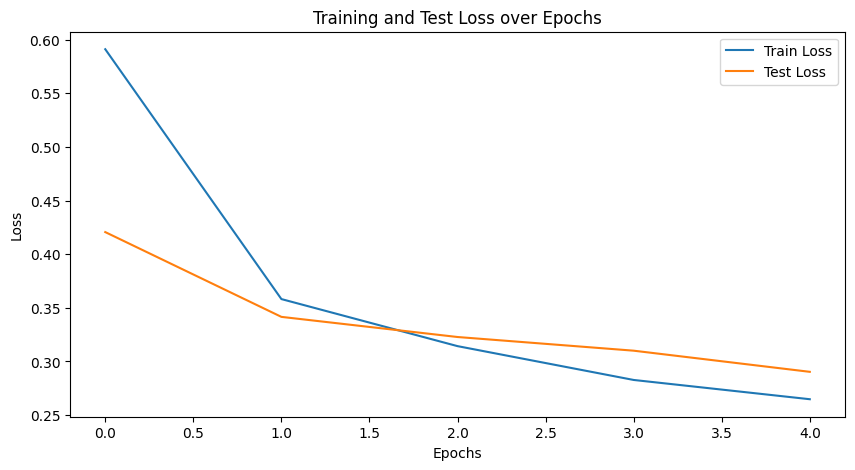

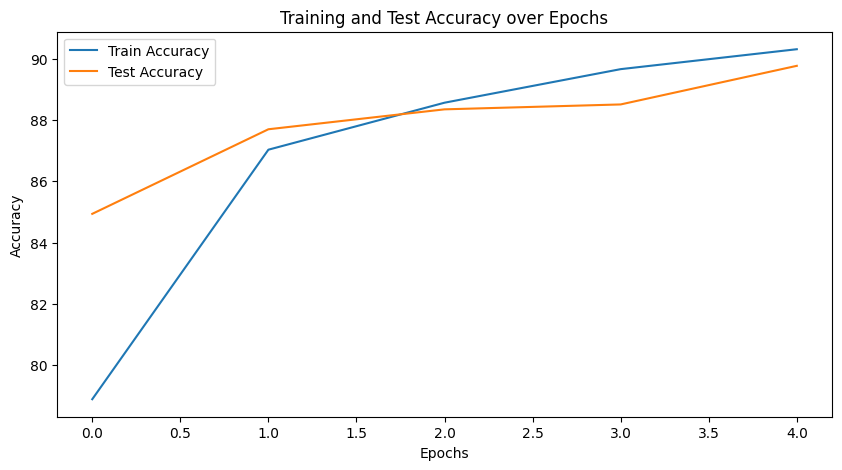

In [66]:
# 모델 학습
# 모델을 학습하는 과정을 수행합니다.
# 손실 함수로는 CrossEntropyLoss를 사용하고, Adam 옵티마이저를 사용하여 모델의 매개변수를 최적화합니다.
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss를 사용하여 손실을 계산합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 옵티마이저를 사용하여 모델을 최적화합니다.

# train_model 함수를 호출하여 모델을 학습하고, 각 에폭에 대한 훈련 및 테스트 손실과 정확도를 반환합니다.
train_losses, test_losses, train_accuracy, test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer)

# 학습 과정 시각화
# 훈련 및 테스트 손실 및 정확도를 시각화하여 학습 과정을 확인합니다.

# 훈련 및 테스트 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss') # 훈련 손실을 그래프에 플롯합니다.
plt.plot(test_losses, label='Test Loss') # 테스트 손실을 그래프에 플롯합니다.
plt.xlabel('Epochs')  # x축 레이블을 설정합니다.
plt.ylabel('Loss') # y축 레이블을 설정합니다.
plt.title('Training and Test Loss over Epochs') # 그래프 제목을 설정합니다.
plt.legend() # 범례를 표시합니다.
plt.show()  # 그래프를 출력합니다.

# 훈련 및 테스트 정확도 시각화
plt.figure(figsize=(10, 5)) 
plt.plot(train_accuracy, label='Train Accuracy') # 훈련 정확도를 그래프에 플롯합니다.
plt.plot(test_accuracy, label='Test Accuracy') # 테스트 정확도를 그래프에 플롯합니다.
plt.xlabel('Epochs') # x축 레이블을 설정합니다.
plt.ylabel('Accuracy') # y축 레이블을 설정합니다.
plt.title('Training and Test Accuracy over Epochs') # 그래프 제목을 설정합니다.
plt.legend() # 범례를 표시합니다.
plt.show() # 그래프를 출력합니다.

We are able to achieve higher accuracy, and much faster, compared to the fully-connected networks.

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

주어진 결과에서 볼 수 있듯이, 모델은 훈련하는 동안 손실이 감소하고 정확도가 증가하는 것을 확인할 수 있습니다. 이는 모델이 훈련 데이터에 대해 잘 학습되고 있다는 것을 나타냅니다. 또한 테스트 데이터에 대한 손실과 정확도 역시 좋은 성능을 보여주고 있습니다.

마지막 에폭에서 훈련 정확도는 약 90.31%이고, 테스트 정확도는 약 89.77%입니다. 이는 모델이 훈련 데이터와 테스트 데이터 모두에서 상당히 높은 정확도를 보이고 있다는 것을 의미합니다.

더욱 더 정확도를 올리고 싶다면 잘못 분류된 이미지를 분석하여 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 확인하면, 추가적인 성능 향상을 위한 개선 방향을 찾을 수도 있을 것 같습니다.